In [1]:
# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture2 as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from matplotlib import figure
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt

2023-03-15 22:13:10.172120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 22:13:10.317603: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 22:13:10.321605: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 22:13:10.321620: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [3]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1200  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 3e6 #This is the maximum number of events that will the program will accept
LR = 3e-4 #This is the default learning rate

In [4]:
particles_input_scaled = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_particles_input_scaled.npy")
re_b_jets_input_scaled = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_re_b_jets_input_scaled.npy")
bhads_targets = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_bhads_targets.npy")
onehot = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_onehot.npy")

In [5]:
particles_input_scaled_train = particles_input_scaled[:int(len(particles_input_scaled)/2)]
re_b_jets_input_scaled_train = re_b_jets_input_scaled[:int(len(re_b_jets_input_scaled)/2)]
bhads_targets_train = bhads_targets[:int(len(bhads_targets)/2)]
onehot_train = onehot[:int(len(onehot)/2)]

In [6]:
particles_input_scaled_test = particles_input_scaled[int(len(particles_input_scaled)/2):]
re_b_jets_input_scaled_test = re_b_jets_input_scaled[int(len(re_b_jets_input_scaled)/2):]
bhads_targets_test = bhads_targets[int(len(bhads_targets)/2):]
onehot_test = onehot[int(len(onehot)/2):]

In [7]:
# Builds the deep neural network
track_layers = [32 for x in range(2)]
jet_layers = [64 for x in range(3)]
b_jets_layers = [32 for x in range(2)]

track_layers = [np.shape(particles_input_scaled)[2]]+track_layers
print(track_layers)
print(np.shape(onehot)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(bhads_targets)[1], n_targets_classification= np.shape(onehot)[1], regularizer_strength= 1e-4, n_features=np.shape(re_b_jets_input_scaled)[1], Dropout_rate=0.1)

from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)


[17, 32, 32]
3


2023-03-15 22:13:24.388775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 22:13:24.388812: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 22:13:24.388832: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vonneumann.csc.warwick.ac.uk): /proc/driver/nvidia/version does not exist
2023-03-15 22:13:24.390236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
path = "/home/physics/phujdj/DeepLearningParticlePhysics/CheckPointsDeepNet/ResidualDeepSetsWeights&BiasesResidualParticles3.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)

In [9]:
DeepSetProjector.load_weights(latest_DeepNet)

In [10]:
DeepSetProjector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 17)]   0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, None, 17)    306         ['input_3[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_residual_unit  (None, None, 17)    646         ['time_distributed[1][0]']       
 s (TimeDistributedResidualUnit                                                                   
 s)                                                                                           

In [12]:
#Evaluate the entire performance of the model
loss = DeepSetProjector.evaluate((particles_input_scaled_train,re_b_jets_input_scaled_train),(bhads_targets_train, onehot_train),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
20124/20124 - 79s - loss: -7.3632e+01 - MultivariateLoss_loss: -7.6312e+01 - MassOutput_loss: 1.0044 - MultivariateLoss_Mean_Squared_Error: 0.0142 - MassOutput_Mean_Squared_Error: 0.2041 - 79s/epoch - 4ms/step
The Loaded DeepNet has loss:  [-73.6318359375, -76.31231689453125, 1.004361867904663, 0.014153634198009968, 0.2040509432554245]


In [11]:
# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = np.histogram(xs, bins=binning)[0]

  yerrs = np.sqrt(ys)

  if normalized:
    s = np.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs
def binneddensitysub(xs, binning, ax, label=None, xlabel=None, ylabel="binned probability density"):
  #fig = figure.Figure(figsize=(8, 8))
  #plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  ax.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    , marker = 'None'
    )

  ax.set_xlabel(xlabel, fontsize = 16)
  ax.set_ylabel(ylabel, fontsize = 16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

  return ax

In [12]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
def kde_generator(x,y, ax, s, alpha, cmap):
    grid = np.vstack([x, y])
    z = gaussian_kde(grid)(grid)
    idx = z.argsort()
    x,y,z = x[idx], y[idx], z[idx]
    im = sns.scatterplot(x,y,c = z,s = s, ax = ax, alpha = alpha, cmap = cmap)
    norm = plt.Normalize(z.min(), z.max())
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    #im.figure.colorbar(sm, cax = ax_2, orientation="horizontal", pad=0.2)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    return ax, sm

In [13]:
def IQR(element):
    return np.quantile(element,0.75) - np.quantile(element,0.25)
plt.rcParams.update({'font.size': 16})
from sklearn.metrics import r2_score
from hffrag import binneddensitysub

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [13]:
print("The Loaded DeepNet has loss: ", loss)

The Loaded DeepNet has loss:  [-73.6318359375, -76.31231689453125, 1.004361867904663, 0.014153634198009968, 0.2040509432554245]


In [15]:
loss = DeepSetProjector.evaluate((particles_input_scaled_test,re_b_jets_input_scaled_test),(bhads_targets_test, onehot_test),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

20124/20124 - 78s - loss: -7.4014e+01 - MultivariateLoss_loss: -7.6698e+01 - MassOutput_loss: 1.0080 - MultivariateLoss_Mean_Squared_Error: 0.0142 - MassOutput_Mean_Squared_Error: 0.2047 - 78s/epoch - 4ms/step
The Loaded DeepNet has loss:  [-74.01424407958984, -76.6980209350586, 1.0079578161239624, 0.01420791819691658, 0.20473526418209076]


In [14]:
predictions = DeepSetProjector.predict((particles_input_scaled_test, re_b_jets_input_scaled_test))
Predictions = predictions[0]
Predictions_Mass = predictions[1]

20124/20124 [==============================] - 61s 3ms/step


In [15]:
lister = []
index = 0
predictions_x = Predictions[:,:np.shape(bhads_targets_test)[1]]
predictions_X = predictions_x
predictions_x_uncertainty = Predictions[:,np.shape(bhads_targets_test)[1]:2*np.shape(bhads_targets_test)[1]]
Predictions_Uncertainty = predictions_x_uncertainty

In [16]:
Error_px_unscaled = (bhads_targets_test[:,0] - predictions_X[:,0])*1e6
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets_test[:,0]*1e6)
Pull_px = Error_px_unscaled/(Predictions_Uncertainty[:,0]*1e6)

In [17]:
Error_py_unscaled = (bhads_targets_test[:,1] - predictions_X[:,1])*1e6
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets_test[:,1]*1e6)
Pull_py = Error_py_unscaled/(Predictions_Uncertainty[:,1]*1e6)

In [18]:
Error_pz_unscaled = (bhads_targets_test[:,2] - predictions_X[:,2])*1e6
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets_test[:,2]*1e6)
Pull_pz = Error_pz_unscaled/(Predictions_Uncertainty[:,2]*1e6)

In [19]:
Error_pt_unscaled = (bhads_targets_test[:,3] - predictions_X[:,3])*1e6
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_test[:,3]*1e6)
Pull_pt = Error_pt_unscaled/(Predictions_Uncertainty[:,3]*1e6)

In [20]:
Error_eta_unscaled = bhads_targets_test[:,4] - predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta_unscaled/np.std(bhads_targets_test[:,4])
Pull_eta = Error_eta_unscaled/Predictions_Uncertainty[:,4]

In [21]:
Error_phi_unscaled = bhads_targets_test[:,5] - predictions_X[:,5]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_test[:,5])
Pull_phi = Error_phi_unscaled/Predictions_Uncertainty[:,5]

In [22]:
Error_energy_unscaled = (bhads_targets_test[:,6] - predictions_X[:,6])*1e6
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_test[:,6]*1e6)
Pull_energy = Error_energy_unscaled/(Predictions_Uncertainty[:,6]*1e6)

In [23]:
Error_ptfraction_unscaled = (bhads_targets_test[:,7] - predictions_X[:,7])*1e6
Pull_ptfraction_unscaled = Error_ptfraction_unscaled/np.std(bhads_targets_test[:,6]*1e6)
Pull_ptfraction = Error_ptfraction_unscaled/(Predictions_Uncertainty[:,7]*1e6)

In [24]:
Error_projection_unscaled = bhads_targets_test[:,8] - predictions_X[:,8]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_test[:,8])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,8]

In [25]:
Error_projectiont_unscaled = bhads_targets_test[:,9] - predictions_X[:,9]
Pull_projectiont_unscaled = Error_projectiont_unscaled/np.std(bhads_targets_test[:,9])
Pull_projectiont = Error_projectiont_unscaled/(Predictions_Uncertainty[:,9])

In [26]:
from hffrag import fixedbinning
from hffrag import binneddensity

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

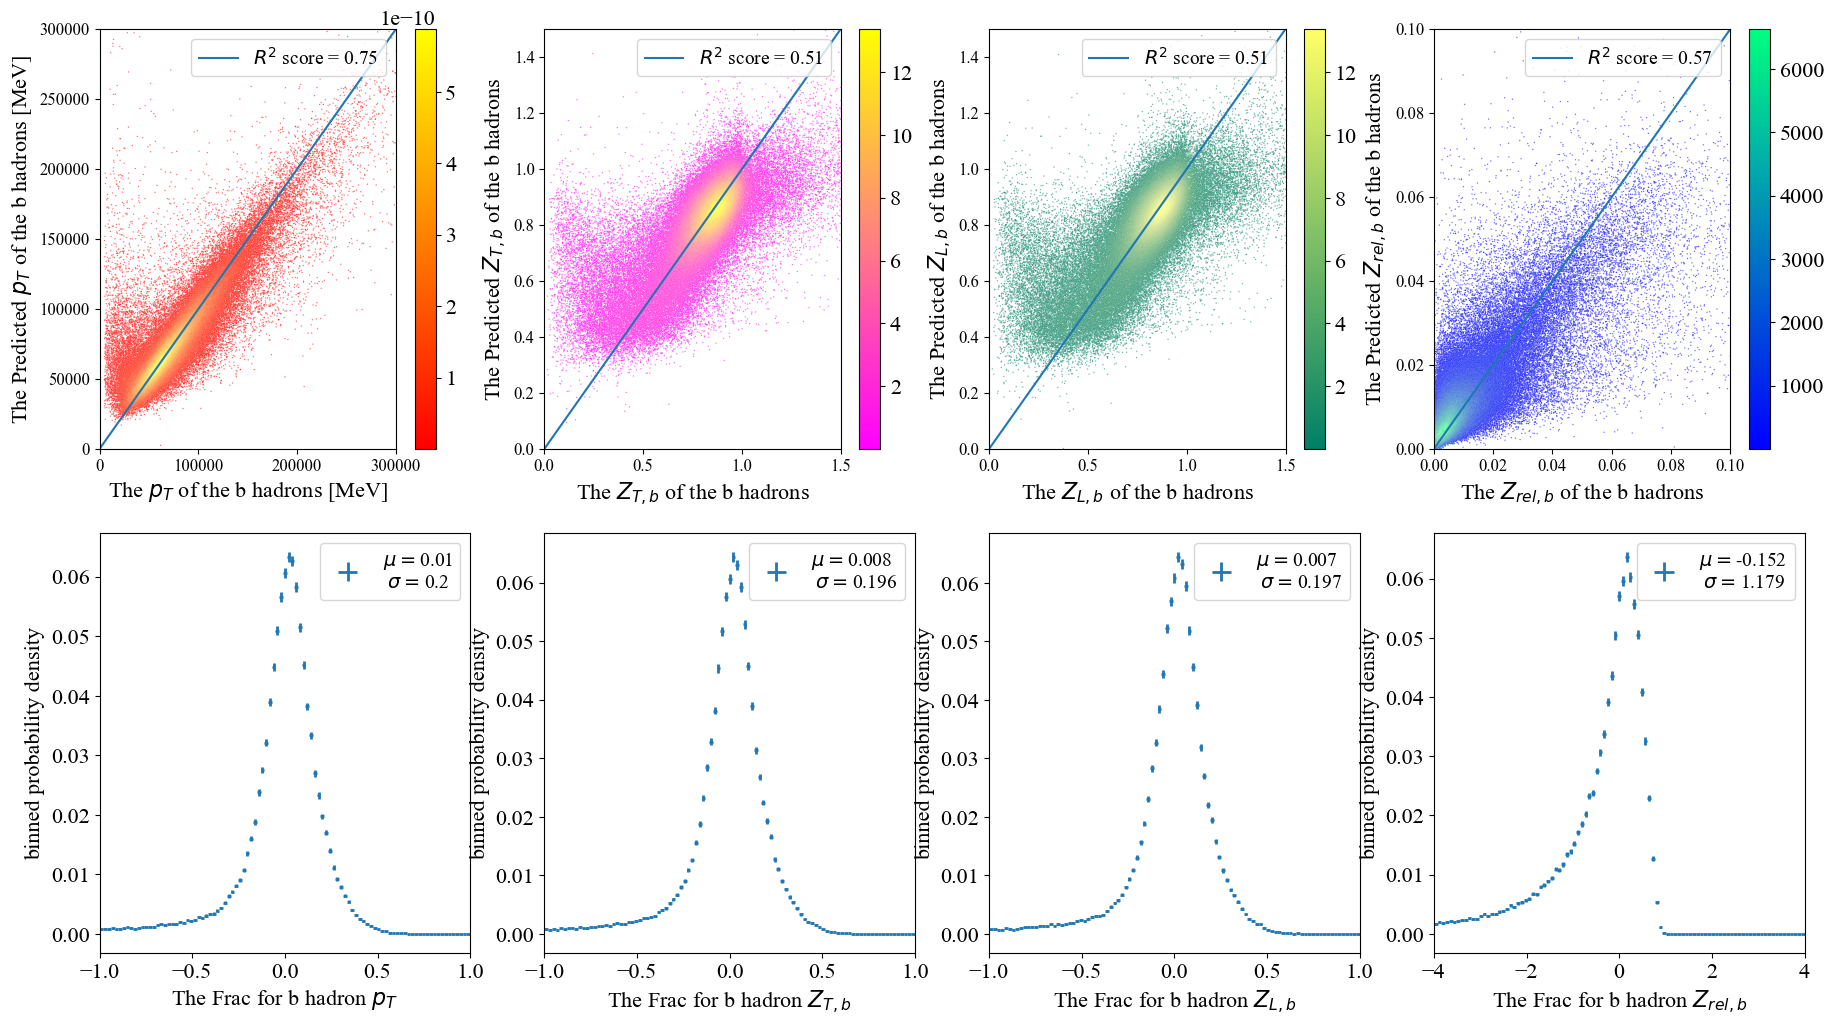

In [66]:
Figure, axes = plt.subplots(2,4, figsize = (22,12))
#l1 = sns.scatterplot(x = bhads_targets[:,3], y = Predictions[:,3], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1, sm_1 = kde_generator(x = bhads_targets_test[:90000,3]*1e6, y = predictions_X[:90000,3]*1e6,ax = axes[0,0], s = 1, alpha = 0.6, cmap = "autumn")
Figure.colorbar(sm_1,ax = axes[0,0])
l1_score = r2_score(bhads_targets_test[:90000,3]*1e6, predictions_X[:90000,3]*1e6)
x = np.linspace(0, 3e5)
l1.set_xlabel("The $p_T$ of the b hadrons [MeV]")
l1.set_ylabel("The Predicted $p_T$ of the b hadrons [MeV]")
error_pt = (bhads_targets_test[:90000,3]*1e6 - predictions_X[:90000,3]*1e6)/(bhads_targets_test[:90000,3]*1e6)
mean_error_pt, std_error_pt = np.median(error_pt), IQR(error_pt)
l1.plot(x,x)
binneddensitysub(error_pt, fixedbinning(-1,1,100), ax = axes[1,0], xlabel= "The Frac for b hadron $p_T$")
#l2 = sns.scatterplot(x = bhads_targets[:,6], y = Predictions[:,6], ax = axes[0,1], s = 1, alpha = 0.6, color = "orange")
l2, sm_2 = kde_generator(x = bhads_targets_test[:90000,7], y = predictions_X[:90000,7], ax = axes[0,1], s = 1, alpha = 0.6, cmap = "spring")
Figure.colorbar(sm_2,ax = axes[0,1])
l2_score = r2_score(bhads_targets_test[:90000,7], predictions_X[:90000,7])
x = np.linspace(0, 4)
error_pt_fraction = (bhads_targets_test[:90000,7] - predictions_X[:90000,7])/bhads_targets_test[:90000,7]
mean_error_pt_fraction, std_error_pt_fraction = np.median(error_pt_fraction), IQR(error_pt_fraction)
l2.plot(x,x)
l2.set_xlabel("The $Z_{T,b}$ of the b hadrons")
l2.set_ylabel("The Predicted $Z_{T,b}$ of the b hadrons")
binneddensitysub(error_pt_fraction, fixedbinning(-1,1,100), ax = axes[1,1], xlabel="The Frac for b hadron $Z_{T,b}$")
#l3 = sns.scatterplot(x = bhads_targets[:,7], y = Predictions[:,7], ax = axes[0,2], s = 1, alpha = 0.6, color = "brown")
l3, sm_3 = kde_generator(x = bhads_targets_test[:90000,8], y = predictions_X[:90000,8], ax = axes[0,2], s = 1, alpha = 0.6, cmap = "summer")
Figure.colorbar(sm_3,ax = axes[0,2])
l3_score = r2_score(bhads_targets_test[:90000,8], predictions_X[:90000,8])
x = np.linspace(0, 4)
error_lprojection = (bhads_targets_test[:90000,8] - predictions_X[:90000 ,8])/bhads_targets_test[:90000,8]
mean_error_lprojection, std_error_lprojection = np.median(error_lprojection), IQR(error_lprojection)
l3.plot(x,x)
l3.set_xlabel("The $Z_{L,b}$ of the b hadrons")
l3.set_ylabel("The Predicted $Z_{L,b}$ of the b hadrons")
binneddensitysub(error_lprojection, fixedbinning(-1,1,100), ax = axes[1,2], xlabel="The Frac for b hadron $Z_{L,b}$")
l4, sm_4 = kde_generator(x = bhads_targets_test[:90000,9], y = predictions_X[:90000,9], ax = axes[0,3], s = 1, alpha = 0.6, cmap = "winter")
Figure.colorbar(sm_4,ax = axes[0,3])
l4_score = r2_score(bhads_targets_test[:90000,9], predictions_X[:90000,9])
x = np.linspace(0, 0.2)
error_tprojection = (bhads_targets_test[:90000,9] - predictions_X[:90000 ,9])/bhads_targets_test[:90000,9]
mean_error_tprojection, std_error_tprojection = np.median(error_tprojection), IQR(error_tprojection)
l4.plot(x,x)
l4.set_xlabel("The $Z_{rel,b}$ of the b hadrons")
l4.set_ylabel("The Predicted $Z_{rel,b}$ of the b hadrons")
binneddensitysub(error_tprojection, fixedbinning(-4,4,100), ax = axes[1,3], xlabel="The Frac for b hadron $Z_{rel,b}$")
axes[0,0].set_ylim(0,3e5)
axes[0,0].legend([f"$R^2$ score = {round(l1_score,2)}"], loc = "upper right", fontsize = 14)
axes[0,0].set_xlim(0,3e5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt,2)}\n $\sigma = ${round(std_error_pt,2)}"], loc = "upper right", fontsize = 14)
axes[0,1].set_xlim(0,1.5)
axes[0,1].set_ylim(0,1.5)
axes[0,1].legend([f"$R^2$ score = {round(l2_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,1].legend([f"$\mu = ${round(mean_error_pt_fraction,3)}\n $\sigma = ${round(std_error_pt_fraction,3)}"], loc = "upper right", fontsize = 14)
axes[0,2].legend([f"$R^2$ score = {round(l3_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,2].legend([f"$\mu = ${round(mean_error_lprojection,3)}\n $\sigma = ${round(std_error_lprojection,3)}"], loc = "upper right", fontsize = 14)
axes[0,3].legend([f"$R^2$ score = {round(l4_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,3].legend([f"$\mu = ${round(mean_error_tprojection,3)}\n $\sigma = ${round(std_error_tprojection,3)}"], loc = "upper right", fontsize = 14)
axes[0,2].set_ylim(0,1.5)
axes[0,2].set_xlim(0,1.5)
axes[0,3].set_ylim(0,0.1)
axes[0,3].set_xlim(0,0.1)
axes[1,0].set_xlim(-1,1)
axes[1,1].set_xlim(-1,1)
axes[1,2].set_xlim(-1,1)
axes[1,3].set_xlim(-4,4)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJetsTestSetPlots.png", dpi = 500)

In [58]:
Pull_pt_mean, Pull_pt_std = np.mean(Pull_pt), np.std(Pull_pt)
Pull_eta_mean, Pull_eta_std = np.mean(Pull_eta), np.std(Pull_eta)
Pull_phi_mean, Pull_phi_std = np.mean(Pull_phi), np.std(Pull_phi)
Pull_pt_mean_fraction, Pull_pt_std_fraction = np.mean(Pull_ptfraction), np.std(Pull_ptfraction)
Pull_projection_mean, Pull_projection_std = np.mean(Pull_projection), np.std(Pull_projection)
Pull_projectiont_mean, Pull_projectiont_std = np.mean(Pull_projectiont), np.std(Pull_projectiont)
Pull_energy_mean, Pull_energy_std = np.mean(Pull_energy), np.std(Pull_energy)

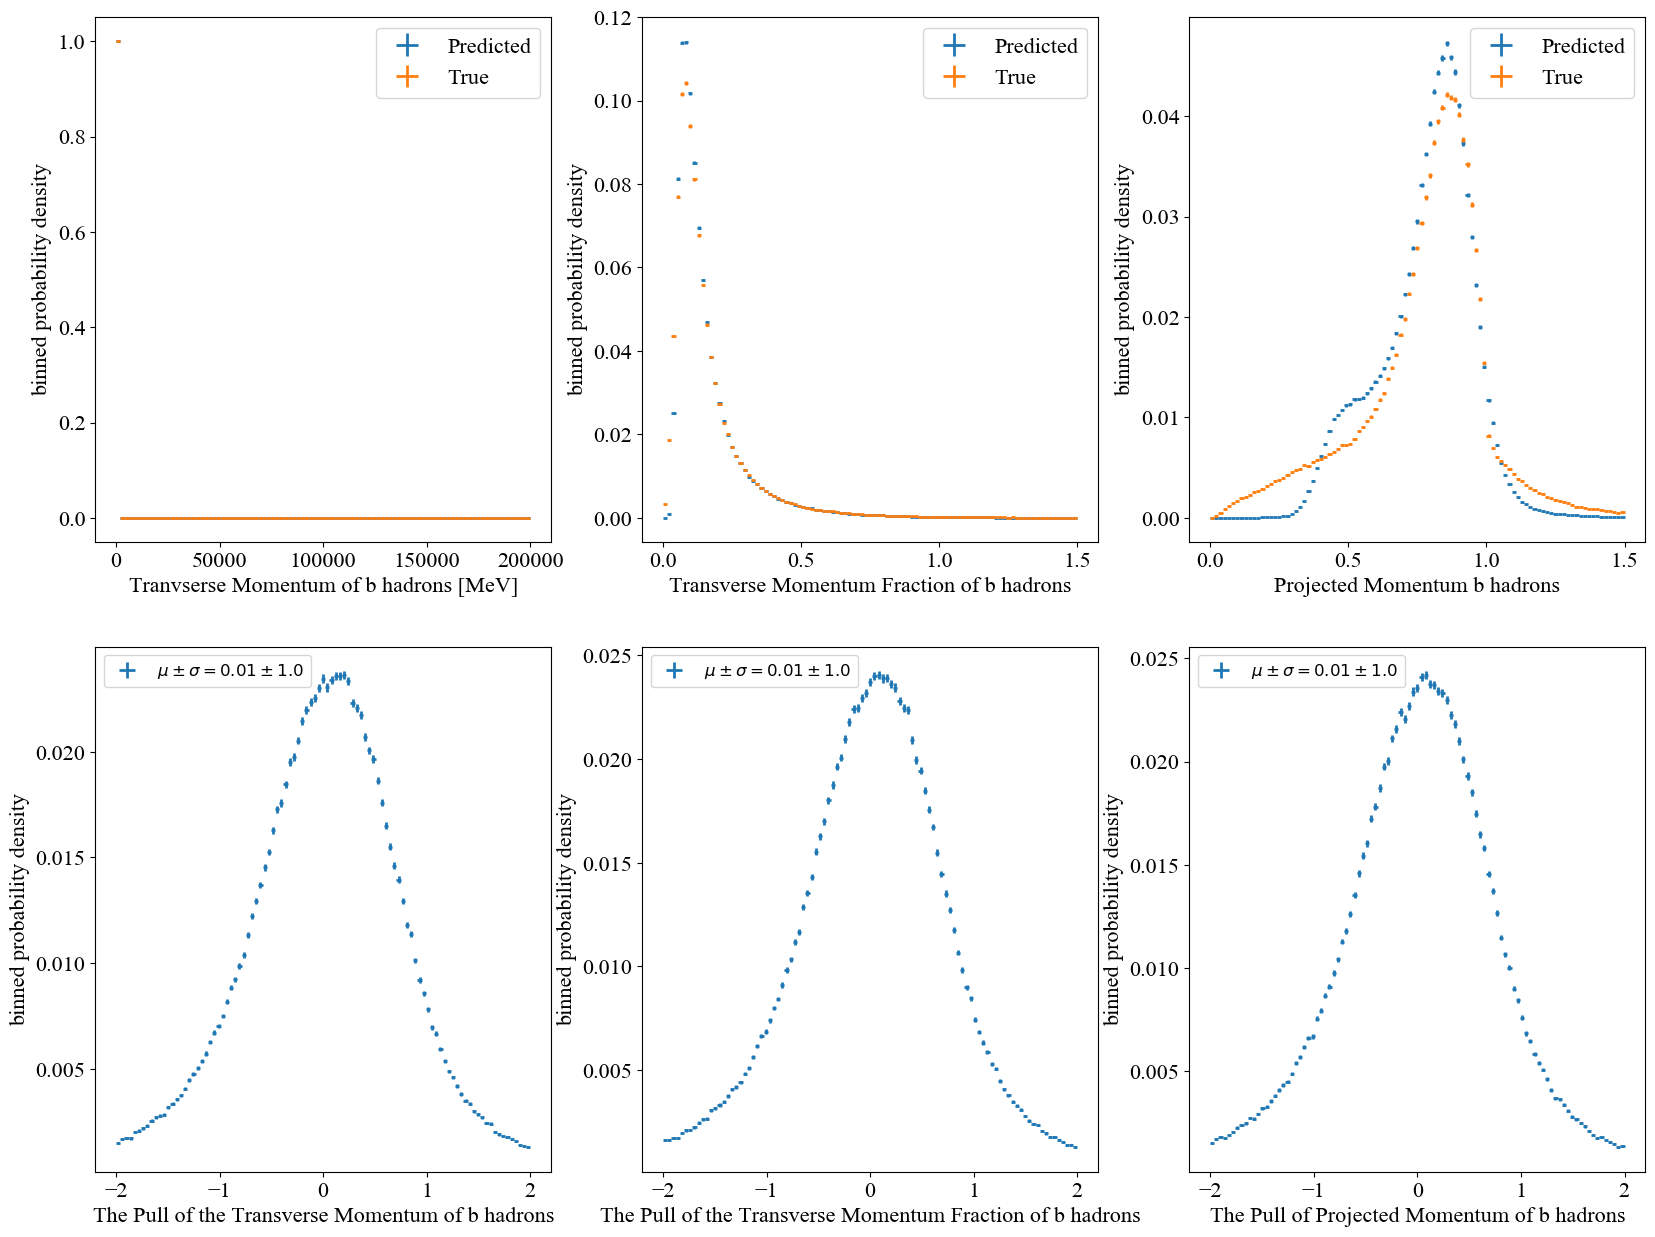

In [59]:
Figure, axes = plt.subplots(2,3, figsize = (20,15))
l1 = binneddensitysub(predictions_X[:,3], fixedbinning(0,2e5,100), ax = axes[0,0], xlabel = "Predicted Tranvserse Momentum of b hadrons [MeV]", label = "Predicted")
l2 = binneddensitysub(predictions_X[:,6], fixedbinning(0,1.5,100), ax = axes[0,1], xlabel = "Predicted Transverse Momentum Fraction of b hadrons", label = "Predicted")
l3 = binneddensitysub(predictions_X[:,7], fixedbinning(0,1.5,100), ax = axes[0,2], xlabel = "Predicted Projected Momentum of b hadrons", label = "Predicted")
l4 = binneddensitysub(bhads_targets_test[:,3], fixedbinning(0,2e5,100), ax = axes[0,0], xlabel = "Tranvserse Momentum of b hadrons [MeV]", label = "True")
l5 = binneddensitysub(bhads_targets_test[:,6], fixedbinning(0, 1.5, 100), ax = axes[0,1], xlabel= "Transverse Momentum Fraction of b hadrons", label = "True")
l6 = binneddensitysub(bhads_targets_test[:,7], fixedbinning(0,1.5,100), ax = axes[0,2], xlabel = "Projected Momentum b hadrons", label = "True")
l7 = binneddensitysub(Pull_pt, fixedbinning(-2,2,100), ax = axes[1,0], xlabel = "The Pull of the Transverse Momentum of b hadrons",)
l8 = binneddensitysub(Pull_ptfraction, fixedbinning(-2,2,100), ax = axes[1,1], xlabel = "The Pull of the Transverse Momentum Fraction of b hadrons")
l9 = binneddensitysub(Pull_projection, fixedbinning(-2,2,100), ax = axes[1,2], xlabel = "The Pull of Projected Momentum of b hadrons")
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean_fraction,2)} \pm {round(Pull_pt_std_fraction,2)}$"], fontsize = 12)
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_projection_mean,2)} \pm {round(Pull_projection_std,2)}$"], fontsize = 12)
axes[1,2].legend([f"$\mu \pm \sigma = {round(Pull_energy_mean,2)} \pm {round(Pull_energy_std,2)}$"], fontsize = 12)
axes[0,0].legend(loc = "upper right")
axes[0,1].legend(loc = "upper right")
axes[0,2].legend(loc = "upper right")
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJetsTestSetPlots2.pdf", dpi = 500)

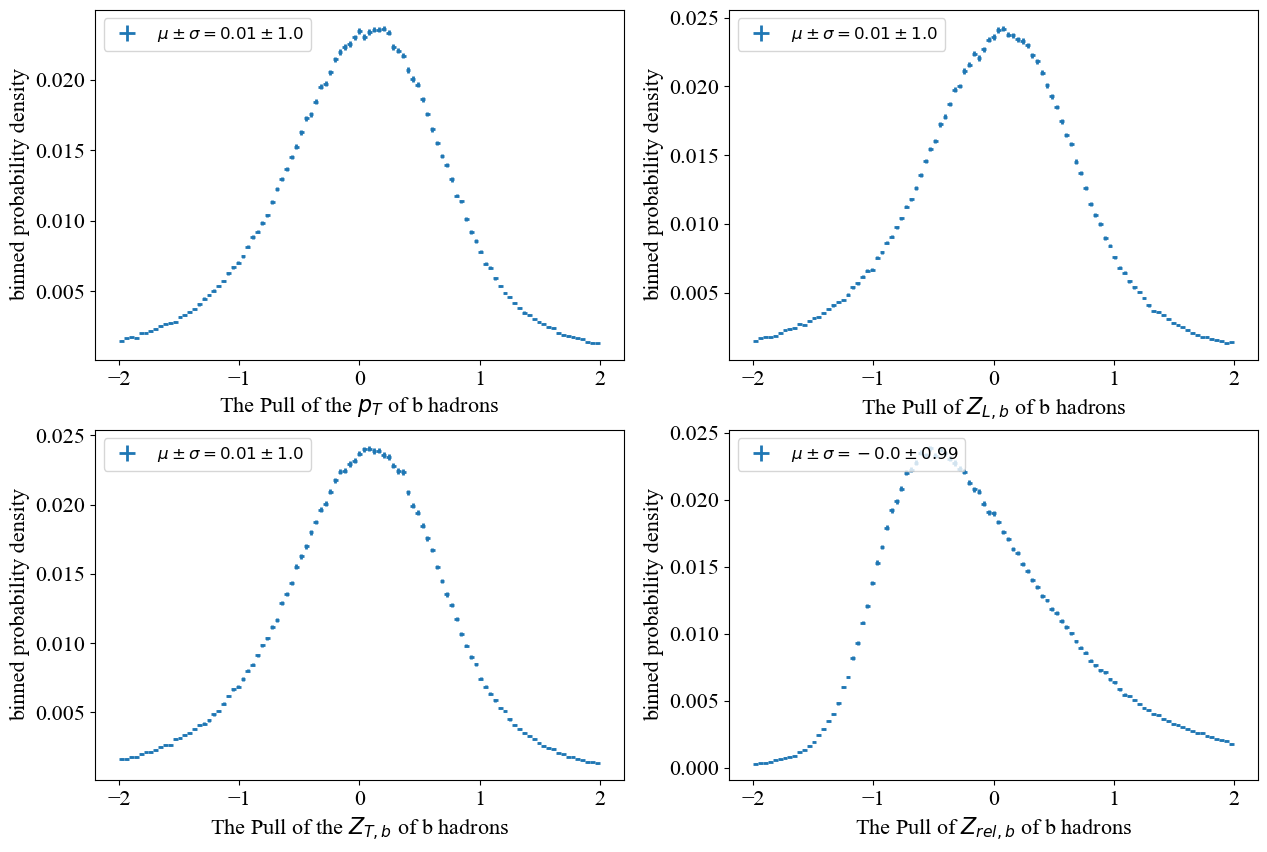

In [67]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
l7 = binneddensitysub(Pull_pt, fixedbinning(-2,2,100), ax = axes[0,0], xlabel = "The Pull of the $p_T$ of b hadrons",)
l8 = binneddensitysub(Pull_ptfraction, fixedbinning(-2,2,100), ax = axes[1,0], xlabel = "The Pull of the $Z_{T,b}$ of b hadrons")
l9 = binneddensitysub(Pull_projection, fixedbinning(-2,2,100), ax = axes[0,1], xlabel = "The Pull of $Z_{L,b}$ of b hadrons")
l10 = binneddensitysub(Pull_projectiont, fixedbinning(-2,2,100), ax = axes[1,1], xlabel = "The Pull of $Z_{rel,b}$ of b hadrons")
axes[0,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean,2)} \pm {round(Pull_pt_std,2)}$"],loc = "upper left", fontsize = 12)
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean_fraction,2)} \pm {round(Pull_pt_std_fraction,2)}$"], loc = "upper left", fontsize = 12)
axes[0,1].legend([f"$\mu \pm \sigma = {round(Pull_projection_mean,2)} \pm {round(Pull_projection_std,2)}$"], loc = "upper left", fontsize = 12)
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_projectiont_mean,2)} \pm {round(Pull_projectiont_std,2)}$"], loc = "upper left", fontsize = 12)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJetsTestSetPlots3.png", dpi = 500)

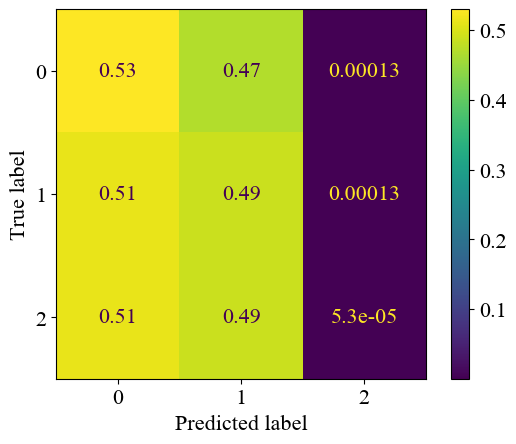

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(np.argmax(onehot_test, axis = 1), np.argmax(Predictions_Mass,axis = 1), normalize='true')
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

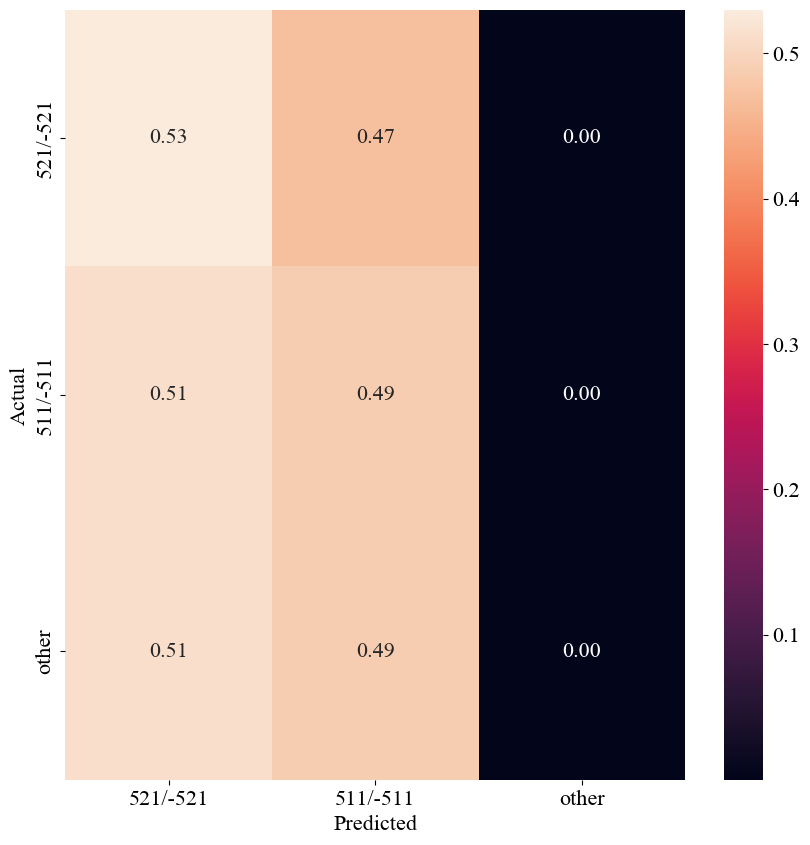

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names = ["521/-521","511/-511","other"]
cm = confusion_matrix(np.argmax(onehot_test,axis = 1), np.argmax(Predictions_Mass,axis = 1))
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

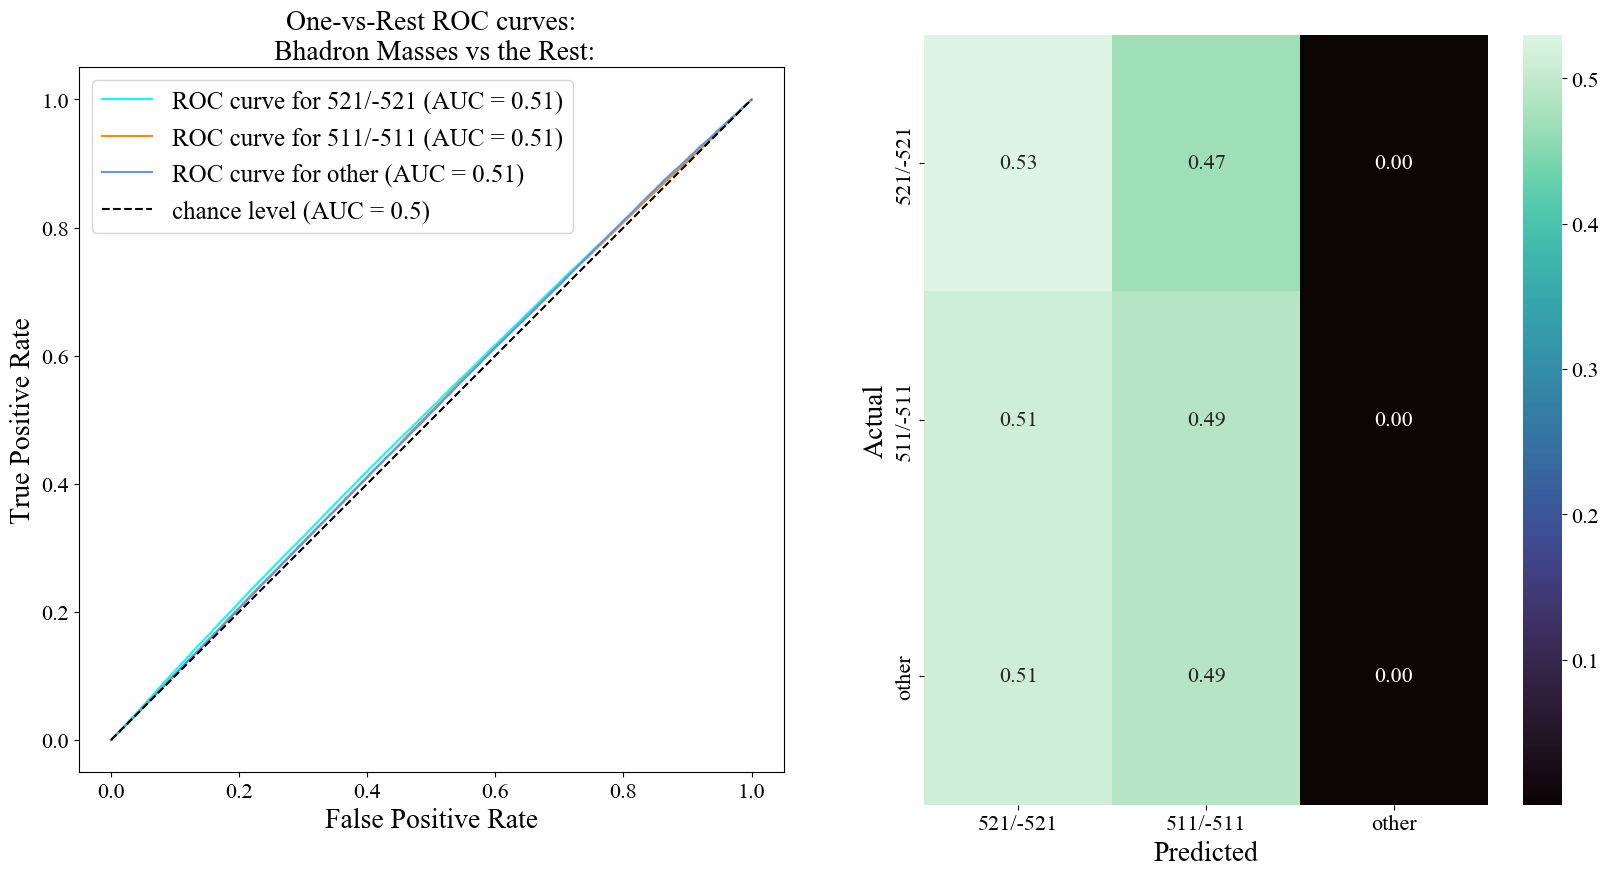

In [56]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
target_names = ["521/-521", "511/-511", "other"]
fig, ax = plt.subplots(1,2,figsize = (20,10))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        onehot_test[:,class_id],
        Predictions_Mass[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax[0],
    )
ax[0].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax[0].axis("square")
ax[0].set_xlabel("False Positive Rate", fontsize = 20)
ax[0].set_ylabel("True Positive Rate", fontsize = 20)
ax[0].set_title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:", fontsize = 20)
ax[0].legend(fontsize = 18)
target_names = ["521/-521","511/-511","other"]
cm = confusion_matrix(np.argmax(onehot_test,axis = 1), np.argmax(Predictions_Mass,axis = 1))
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax[1] = sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names, cmap = "mako")
ax[1].set_ylabel('Actual', fontsize = 20)
ax[1].set_xlabel('Predicted', fontsize = 20)
plt.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJetsROCConfusionMatrix.png", dpi = 500)
plt.show()